In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from keras import metrics
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
import os
import cv2 as cv


In [2]:
# Veri setinin yolu
path = 'C:/Users/YourName/Desktop/HouseDataset'

In [3]:
# Etiketleri kodlamak için kullanılacak fonksiyon
def encode_labels(labels):
    labels = np.where(labels == 'Bathroom', 0, labels)
    labels = np.where(labels == 'Bedroom', 1, labels)
    labels = np.where(labels == 'Frontal', 2, labels)
    labels = np.where(labels == 'Kitchen', 3, labels)
    return labels.astype(np.float32)

In [4]:
# Resimleri düzeltmek için kullanılacak fonksiyon
def fix_images(images, avgHeight, avgWidth):
    temp = images.copy()
    for i in range(len(temp)):
        temp[i] = cv.resize(temp[i], (int(avgWidth), int(avgHeight)))
    return temp

In [5]:
# Veri setinden resimleri ve etiketleri yükleme
images, labels = [], []
avgHeight, avgWidth = 0, 0
for category in os.listdir(path):
    category_path = os.path.join(path, category)
    if os.path.isdir(category_path):
        for filename in os.listdir(category_path):
            img = cv.imread(os.path.join(category_path, filename))
            if img is not None:
                images.append(img)
                labels.append(category)

In [6]:
# Resimleri düzeltme
image_width = 100
image_height = 75
fixed_images = fix_images(images, image_height, image_width)
fixed_images, labels = np.array(fixed_images), np.array(labels)
fixed_images = fixed_images / 255

In [7]:
# Etiketleri dönüştürme
fixed_labels = labels.reshape(labels.shape[0], 1)
fixed_labels = encode_labels(fixed_labels)

In [8]:
# Eğitim ve test setlerini ayırma
X_train, X_test, y_train, y_test = train_test_split(
    fixed_images, fixed_labels, test_size=0.2, random_state=20)

In [9]:
# CNN modeli oluşturma
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(image_height, image_width, 3)),
    MaxPooling2D(),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])


In [10]:
# Modeli derleme
model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy', metrics.CategoricalAccuracy(), metrics.MeanSquaredError()])

In [11]:
# Model özetini gösterme
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 73, 98, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 36, 49, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 34, 47, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 17, 23, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 15, 21, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 7, 10, 128)       0

In [12]:
# Modeli eğitme
hist = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
54/54 [==============================] - 10s 136ms/step - loss: 1.0600 - accuracy: 0.5076 - categorical_accuracy: 0.1799 - mean_squared_error: 2.8899 - val_loss: 0.8033 - val_accuracy: 0.6682 - val_categorical_accuracy: 0.3692 - val_mean_squared_error: 2.7273
Epoch 2/10
54/54 [==============================] - 7s 121ms/step - loss: 0.8226 - accuracy: 0.6460 - categorical_accuracy: 0.2634 - mean_squared_error: 2.9212 - val_loss: 0.8251 - val_accuracy: 0.6285 - val_categorical_accuracy: 0.1005 - val_mean_squared_error: 2.7491
Epoch 3/10
54/54 [==============================] - 6s 116ms/step - loss: 0.7208 - accuracy: 0.6968 - categorical_accuracy: 0.2442 - mean_squared_error: 2.9351 - val_loss: 0.7055 - val_accuracy: 0.6893 - val_categorical_accuracy: 0.4346 - val_mean_squared_error: 2.7562
Epoch 4/10
54/54 [==============================] - 5s 92ms/step - loss: 0.6363 - accuracy: 0.7418 - categorical_accuracy: 0.2553 - mean_squared_error: 2.9452 - val_loss: 0.6041 - val_accur

In [13]:
# Metrics değerleri yazdırma
# Eğitim doğruluk değerleri
train_accuracy = hist.history['accuracy']

# Eğitim ortalama karesel hata değerleri
train_mse = hist.history['mean_squared_error']

# Doğrulama doğruluk değerleri
val_accuracy = hist.history['val_accuracy']

# Doğrulama ortalama karesel hata değerleri
val_mse = hist.history['val_mean_squared_error']

# Verileri bir DataFrame'e dönüştürme
history_df = pd.DataFrame({
    'Train Accuracy': train_accuracy,
    'Train MSE': train_mse,
    'Validation Accuracy': val_accuracy,
    'Validation MSE': val_mse
})

# DataFrame'i düzenli bir şekilde yazdırma
print(history_df)

   Train Accuracy  Train MSE  Validation Accuracy  Validation MSE
0        0.507593   2.889941             0.668224        2.727330
1        0.646028   2.921204             0.628505        2.749139
2        0.696846   2.935062             0.689252        2.756167
3        0.741822   2.945187             0.780374        2.757312
4        0.762266   2.952789             0.787383        2.774702
5        0.782126   2.961397             0.787383        2.779692
6        0.803154   2.967114             0.792056        2.776125
7        0.821262   2.968607             0.771028        2.784781
8        0.828855   2.972666             0.750000        2.797017
9        0.842290   2.978138             0.810748        2.790295


In [14]:
# Basarı Metrikleri Hesaplama
y_train_predicted = model.predict(X_train)
y_train_predicted = np.argmax(y_train_predicted, axis=1) # En yüksek olasılığa sahip sınıfın etiketini/alındeksi alın
train_accuracy = np.mean(y_train_predicted == y_train)
print("\nTrain Accuracy: ", train_accuracy)

y_test_predicted = model.predict(X_test)
y_test_predicted = np.argmax(y_test_predicted, axis=1) # En yüksek olasılığa sahip sınıfın etiketini/alındeksi alın
test_accuracy = np.mean(y_test_predicted == y_test)
print("\nTest Accuracy: ", test_accuracy)

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted))

54/54 [==============================] - 1s 22ms/step

Train Accuracy:  0.24988740828893352
14/14 [==============================] - 0s 25ms/step

Test Accuracy:  0.25350467289719625

Test Confusion Matrix:
[[100   8   1   5]
 [ 18  91   0   9]
 [  1   1  87   3]
 [ 18  16   1  69]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.73      0.88      0.80       114
         1.0       0.78      0.77      0.78       118
         2.0       0.98      0.95      0.96        92
         3.0       0.80      0.66      0.73       104

    accuracy                           0.81       428
   macro avg       0.82      0.81      0.82       428
weighted avg       0.82      0.81      0.81       428



In [15]:
# Modeli kayıt etme
model.save('housemodel.h5')

In [16]:
# Örnek bir fotoğraf test etme
sample_image_path = 'C:/Users/YourName/Desktop/test/test4.jpg'  # Test edilecek örnek fotoğrafın yolunu buraya girin
sample_image = cv.imread(sample_image_path)
sample_image = cv.resize(sample_image, (image_width, image_height))
sample_image = sample_image / 255
sample_image = np.expand_dims(sample_image, axis=0)
prediction = model.predict(sample_image)
predicted_label = np.argmax(prediction)

1/1 [==============================] - 0s 21ms/step


In [17]:
# Tahmin sonucunu yazdırma
labels_dict = {0: 'Bathroom', 1: 'Bedroom', 2: 'Frontal', 3: 'Kitchen'}
predicted_category = labels_dict[predicted_label]
print("Predicted class probabilities:", prediction)
print("Predicted category:", predicted_category)

Predicted class probabilities: [[0.09321236 0.29340175 0.00245457 0.61093134]]
Predicted category: Kitchen


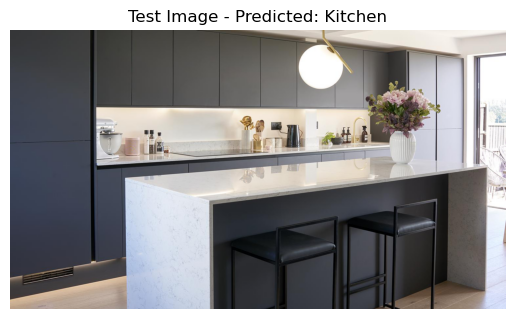

In [18]:
# Örnek fotoğrafı grafik üzerinde gösterme
fig, ax = plt.subplots()
ax.imshow(cv.cvtColor(cv.imread(sample_image_path), cv.COLOR_BGR2RGB))
ax.set_title("Test Image - Predicted: " + predicted_category)
ax.axis("off")
plt.show()